In [1]:
from sympy import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Enable the mathjax printer
init_printing(use_latex='mathjax')

## --> Classe Robô

In [ ]:
class Robot:
    def __init__(self, configuration:str, dh_table:Matrix, name:str='Cocoabot', **matrices):
        """
        Initialize the robot

        Parameters:
        configuration: str
            Set the joint types: 'RRR', 'RRP', ...
        
        dh_table: sympy.Matrix
            Table with Denavit-Hartenberg parameters.
            Use (theta, d, a, alpha) for each joint.
        
        name: str
            Define a name for the robot.
        
        matrices: sympy.Matrix
            masses:     Matrix with the mass of each link: [m1, m2, m3].T (nx1)
            r_cis:      Matrix with the com of each link (local): [ci1, ci2, ci3].T (nx1)
            inertias:   Matrix with the inertia of each link: [[I11:4], [I21:4], [I31:4]] (3x3)
            g_vec:      Matrix with the gravity vector: [0 0 -g].T (3x1)        
        """
        self.name = name
        self.joint_types = list(configuration)
        self.dof = len(self.joint_types)

        self.joints = pd.DataFrame(columns=['type', 'theta', 'd', 'a', 'alpha'])
        self.t = symbols('t')
        self.q = [Function(f'q{i+1}')(self.t) for i in range(self.dof)]
        self.dq = [qi.diff(self.t) for qi in self.q]
        self.ddq = [dqi.diff(self.t) for dqi in self.dq]
        self.set_matrices(**matrices)
        self.set_dh_params(dh_table)
        self.get_joints()
        self.compute()

    def set_matrices(self, **matrices):
        """
        Set the mass, center of mass, inertia and gravity matrices

        Parameters:
        matrices: sympy.Matrix
            masses:     Matrix with the mass of each link: [m1, m2, m3].T (nx1)
            r_cis:      Matrix with the com of each link (local): [ci1, ci2, ci3].T (nx1)
            inertias:   Matrix with the inertia of each link: [[I11:4], [I21:4], [I31:4]] (3x3)
            g_vec:      Matrix with the gravity vector: [0 0 -g].T (3x1) 

        Default:
            All parameters are defined symbolic.
        """
        self.masses_symbols = Matrix(symbols(f'm1:{self.dof+1}'))
        self.masses = matrices.get('masses', self.masses_symbols)
        self.r_cis_local = matrices.get('r_cis', [Matrix(symbols(f'r_{i+1}x:z')) for i in range(self.dof)])
        self.inertias_symbols = [symbols(f'I{i+1}_1:4_1:4') for i in range(3)]
        self.inertias = matrices.get('inertias', [Matrix(3,3,self.inertias_symbols[i]) for i in range(self.dof)])
        self.g_symbol = symbols('g')
        self.g_vec = matrices.get('g_vec', Matrix([0, 0, -self.g_symbol]))
    
    def set_dh_params(self, dh_table):
        """
        Set the Denavit Hartenberg parameters

        Parameters:
        dh_table: list of lists
            Each list represent the DH-parameters of a joint in the order (theta, d, a, alpha)
        """
        self.thetas = dh_table[:,0]
        self.ds = dh_table[:,1]
        self._as_ = dh_table[:,2]
        self.alphas = dh_table[:,3]
    
    def get_joints(self):
        """
        Generates the DH Table amd substitutes the symbolic q with symbolic function q(t)
        """
        q = symbols(f'q1:{self.dof+1}')
        for tp in self.joint_types:
            if tp == 'R': self.thetas = self.thetas.subs(zip(q,self.q))
            if tp == 'P': self.ds = self.ds.subs(zip(q,self.q))
        self.joints = pd.DataFrame(list(zip(self.joint_types, Matrix(self.thetas), self.ds, self._as_, self.alphas)), 
                                   columns=['type', 'theta', 'd', 'a', 'alpha'], 
                                   index=np.arange(self.dof)+1)
    
    def compute(self):
        """
        Computes all the kinematics and dynamics and saves the information in attributes
        """
        # Kynematics
        self.dh_matrices = [self.compute_dh_matrix(joint_index=i+1) for i in range(self.dof)]
        self.base_to_joint = [self.calculate_base_to_joint(joint_end=i+1) for i in range(self.dof)]
        self.base_to_end_effector = self.base_to_joint[-1]
        self.jacobian = self.calculate_jacobian()
        # Center of Mass
        self.r_cis_global = [self.calculate_r_i_ci(joint_index=i+1) for i in range(self.dof)]
        self.jacobian_ci = self.calculate_jacobian(com=True)
        # Dynamics
        self.inertia_matrix = self.calculate_inertia_matrix()
        self.coriolis_matrix = self.calculate_coriolis_matrix()
        self.gravity_vector = self.calculate_gravity_vector()
        self.torques = self.compute_inverse_dynamics()

    def compute_dh_matrix(self, joint_index:int):
        """
        Compute the Denavit-Hartenberg transformation matrix for a given joint.

        Parameters:
        joint_index: int 

        Returns:
        sympy.Matrix
            Denavit-Hartenberg transformation matrix
        """
        assert joint_index > 0, "Must be positive."
        i = joint_index - 1
        theta, d, a, alpha = self.thetas[i], self.ds[i], self._as_[i], self.alphas[i]
        T = Matrix([[cos(theta), -sin(theta)*cos(alpha), sin(theta)*sin(alpha), a*cos(theta)],
                     [sin(theta), cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)],
                     [0, sin(alpha), cos(alpha), d],
                     [0, 0, 0, 1]])
        return T
    
    def calculate_joint_to_joint(self, joint_start:int, joint_end:int):
        """
        Computes the transformation matrix from a starting joint to an ending joint.

        Parameters:
        joint_start: int
            Index of starting joint.

        end_joint: int
            Index of ending joint.

        Returns:
        sympy.Matrix
            Transformation matrix from starting to ending joint
        """
        assert joint_start > 0, "Must be positive."
        assert joint_end >= joint_start, "End must be greater than start."
        result = eye(self.dof + 1)
        for i in range(joint_start, joint_end+1):
            result = result @ self.dh_matrices[i-1]
        return simplify(result)
    
    def calculate_base_to_joint(self, joint_end):
        """
        Computes the transformation matrix from base to an ending joint
        """
        return self.calculate_joint_to_joint(joint_start=1, joint_end=joint_end)
    
    def calculate_base_to_end_effector(self):
        """
        Computes the transformation matrix from base to end-effector.
        """
        return self.calculate_base_to_joint(joint_end=self.dof)
    
    def get_rotation(self, matrix):
        """
        Selects the Rotation Matrix from the Transformation Matrix.
        """
        return matrix[:self.dof,:self.dof]
    
    def get_translation(self, matrix):
        """
        Selects the Translation Matrix from the Transformation Matrix.
        """
        return matrix[:self.dof,-1:]

    def z_i_minus_one(self, joint_index):
        """
        Calculates the orientation of the z axis for the desired joint.
        This will be used to calculate the Jacobian.

        Parameters:
        joint_index: int
        """
        result = eye(self.dof)
        for i in range(1, joint_index):
            result = result @ self.get_rotation(self.dh_matrices[i-1])
        # result = self.get_rotation(self.base_to_joint[joint_index-1])
        result = result @ Matrix([0, 0, 1])
        return simplify(result)
    
    def r_i_minus_one_to_n(self, joint_index, joint_ci=None):
        """
        Calculates the position of the desired joint relative to the end-effector.
        This will be used to calculate the Jacobian.

        Parameters:
        joint_index: int 

        joint_ci: int
            Considers the center of mass of joint {joint_ci}
        """
        com = joint_ci is not None
        if not com:
            return self.get_translation(self.base_to_end_effector - self.base_to_joint[joint_index-1]) \
                    if joint_index > 1 else self.get_translation(self.base_to_end_effector)
        else:
            return self.r_cis_global[joint_ci-1] - self.get_translation(self.base_to_joint[joint_index - 1])

    def calculate_r_i_ci(self, joint_index):
        """
        The same as self.r_i_minus_one_to_n(), but considering the position of the center of mass of the links.
        """
        r_local = Matrix.vstack(self.r_cis_local[joint_index-1], Matrix([1]))
        r_ci_global = self.base_to_joint[joint_index-1] @ r_local
        return simplify(r_ci_global[:-1,:])

    def calculate_jacobian_col_i(self, joint_index:int, joint_ci=None):
        """
        Computes the columns of the jacobian matrix.

        Parameters:
        joint_index: int
            Defines which column to be computed.

        joint_ci: int (Optional)
            Defines which link (center of mass) to consider.
        
        Returns:
        sympy.Matrix
            Single column of the jacobian matrix (6 x 1)
        """
        com = joint_ci is not None
        if com:
            if joint_ci < joint_index:
                return Matrix(6*[0])
        joint_type = self.joint_types[joint_index-1]
        if joint_type == 'R':
            J_vi = Matrix(np.cross(self.z_i_minus_one(joint_index).T, self.r_i_minus_one_to_n(joint_index, joint_ci).T)).T
            J_wi = self.z_i_minus_one(joint_index)
        elif joint_type == 'P':
            J_vi = self.z_i_minus_one(joint_index)
            J_wi = Matrix([0, 0, 0])
        J_i = Matrix(np.vstack((J_vi, J_wi)))
        return simplify(J_i)

    def calculate_jacobian(self, com=False):
        """
        Calculates the jacobian matrix of the robot. 

        Parameters:
        com: bool
            If False, relative to end-effector. (Default)
            If True, relative to center of mass of each link.

        Returns:
        sympy.Matrix
            Jacobian matrix (6 x n).
        """
        if not com:
            return Matrix(np.hstack(tuple((self.calculate_jacobian_col_i(i+1) for i in range(self.dof)))))
        else:
            return [Matrix(np.hstack(tuple((self.calculate_jacobian_col_i(j+1, i+1) 
                    for j in range(self.dof)))))
                    for i in range(self.dof)]

    def calculate_inertia_matrix(self):
        """
        Calculates the inertia matrix of the robot.

        Returns:
        sympy.Matrix
            Inertia matrix (3 x 3).
        """
        inertia_matrix = zeros(self.dof, self.dof)

        for i in range(self.dof):
            jv = self.jacobian_ci[i][:3, :]
            jw = self.jacobian_ci[i][3:, :]
            inertia_matrix += self.masses[i] * (jv.T @ jv) + (jw.T @ self.inertias[i] @ jw)

        return simplify(inertia_matrix)

    def calculate_coriolis_matrix(self):
        """
        Calculate the Coriolis matrix C(q).

        Returns:
        sympy.Matrix
            Coriolis matrix (n x n).
        """
        n = self.dof
        # q = symbols(f'q1:{n+1}')
        # dq = symbols(f'dq1:{n+1}')

        M = self.inertia_matrix
        C = zeros(n, n)
        for i in range(n):
            for j in range(n):
                for k in range(n):
                    c_ijk = 0.5 * (diff(M[i, k], self.q[j]) + diff(M[i, j], self.q[k]) - diff(M[j, k], self.q[i]))
                    C[i, j] += c_ijk * self.dq[k]

        return simplify(C)

    def calculate_gravity_vector(self):
        """
        Calculate the gravity vector G(q) by differentiating the total potential energy.

        Returns:
        sympy.Matrix
            Gravity vector.
        """
        U = 0
        for i, com in enumerate(self.r_cis_global):
            U += self.masses[i] * self.g_vec.dot(com)
        # Differentiating the total potential energy
        G = Matrix([diff(U, q_i) for q_i in self.q])
        return G
    
    def compute_inverse_dynamics(self):
        """
        Computes the torque and forces in each joint.

        Returns:
        sympy.Matrix
            Torques/forces (n x 1)
        """
        self.q_d = [Function(f'q_{i+1}d')(self.t) for i in range(self.dof)]
        self.dq_d = [qi.diff(self.t) for qi in self.q_d]
        self.ddq_d = [dqi.diff(self.t) for dqi in self.dq_d]

        M = self.inertia_matrix
        C = self.coriolis_matrix
        G = self.gravity_vector
        tau = M.subs(zip(self.q,self.q_d)) @ Matrix(self.ddq_d) + \
              C.subs(zip(self.q,self.q_d)).subs(zip(self.dq, self.dq_d)) @ Matrix(self.dq_d) + \
              G.subs(zip(self.q,self.q_d))
        return simplify(tau)

    def eval_dinamics(self, tau, q_d=None, dq_d=None, ddq_d=None):
        """
        Substitutes the symbolic variables with numeric or other symbolic values.

        Parameters:
        q_d:
            Desired position/trajectory.

        dq_d:
            Desired velocity.
        
        ddq_d:
            Desired acceleration.
        
        Note:
            Be aware of the order of operations implemented and check the result.
        """
        # Importante manter esta ordem!
        if ddq_d: tau = tau.subs(zip(self.ddq_d, ddq_d))
        if dq_d: tau = tau.subs(zip(self.dq_d, dq_d))
        if q_d: tau = tau.subs(zip(self.q_d, q_d))
        return tau.simplify()
    
    def eval_matrix(self, matrix, q=None, dq=None, ddq=None):
        # Importante manter esta ordem!
        if ddq: matrix = matrix.subs(zip(self.ddq, ddq))
        if dq: matrix = matrix.subs(zip(self.dq, dq))
        if q: matrix = matrix.subs(zip(self.q, q))
        return matrix.simplify()

## --> Definição do robô

In [108]:
# == Define Configuration == #
configuration = 'RRP'
dof = len(configuration)


# == Define Masses == #
m1, m2, m3 = Matrix(symbols(f'm_1:4'))
masses = Matrix([m1, 0, m3])
L1, L2 = symbols('L_1 L_2')


# == Define inertias == #
inertias = [diag(*symbols('I_1x:z')), diag(0,0,0), diag(*symbols('I_3x:z'))]


# == Define Center of Mass (local) == #
cm1, cm2, cm3 = symbols(f'r_1:4')
r_cis = [Matrix([0, 0, cm]) for cm in [cm1, cm2, cm3]]
# r_cis = [Matrix([0, 0, cm]) for cm in [L1/2, 0, L2/2]] 


# == Define gravity vector (base) == #
g_vec = Matrix([0, 0, -symbols('g')])


# == Define DH parameters == #
# q1, q2, q3 = symbols('q_1:4')
tsym = symbols('t')
q1, q2, q3 = [Function(f'q{i+1}')(tsym) for i in range(3)]

# == DH Table == #
dh_table = Matrix(
    [[q1, L1, 0, pi/2],
    [q2, 0, 0, pi/2],
    [pi/2, q3+L2, 0, 0]]
)

# == Creating the Robot == #
r = Robot(configuration='RRP', dh_table=dh_table, masses=masses, r_cis=r_cis, inertias=inertias)    # masses=masses, r_cis=r_cis, g_vec=g_vec, inertias=inertias
r.joints

,type,theta,d,a,alpha
1,R,q1(t),L_1,0,pi/2
2,R,q2(t),0,0,pi/2
3,P,pi/2,L_2 + q3(t),0,0


## --> Parâmetros que da pra calcular

In [4]:
# DH Parameters
# r.thetas, r.ds, r._as_, r.alphas

In [5]:
# DOF, q, dq, ddq, 
# r.dof, r.q, r.dq, r.ddq

In [112]:
# Masses, Inertias, gravity vector
# r.masses, r.inertias, r.g_vec

In [7]:
# Position of center of mass (local and global)
# r.r_cis_local, r.r_cis_global

In [8]:
# Transition Matrix: i-1 -> i
# r.dh_matrices

In [114]:
# Transition Matrix: 0 -> i
# r.base_to_joint

In [116]:
# Transition Matrix: 0 -> n (dof) [from base to end effector]
# r.base_to_end_effector

In [11]:
# Jacobian (end effector)
# r.jacobian

In [12]:
# Jacobian for each center of mass
# r.jacobian_ci

### Inercia, Coriolis, gravidade e Torque

- Resultados simbólicos obtidos para Inercia (M), Coriolis (C), gravidade (G) e torque (tau)

In [13]:
# Inertia Matrix
r.inertia_matrix

⎡                   2                       2    2                             ↪
⎢I_1z + I_3z + m₁⋅r₁  + m₃⋅(L₂ + r₃ + q₃(t)) ⋅sin (q₂(t))                      ↪
⎢                                                                              ↪
⎢                                                                 2            ↪
⎢                           0                              I₃ₓ⋅sin (q₁(t)) + I ↪
⎢                                                                              ↪
⎣                           0                                                  ↪

↪                                            ⎤
↪          0                               0 ⎥
↪                                            ⎥
↪        2                              2    ⎥
↪ _3y⋅cos (q₁(t)) + m₃⋅(L₂ + r₃ + q₃(t))   0 ⎥
↪                                            ⎥
↪          0                               m₃⎦

In [14]:
# Coriolis/Centripetal
r.coriolis_matrix

⎡       ⎛                             d                      d        ⎞        ↪
⎢1.0⋅m₃⋅⎜(L₂ + r₃ + q₃(t))⋅cos(q₂(t))⋅──(q₂(t)) + sin(q₂(t))⋅──(q₃(t))⎟⋅(L₂ +  ↪
⎢       ⎝                             dt                     dt       ⎠        ↪
⎢                                                                              ↪
⎢                             2              d                                 ↪
⎢   - 0.5⋅m₃⋅(L₂ + r₃ + q₃(t)) ⋅sin(2⋅q₂(t))⋅──(q₁(t)) + 0.5⋅(I₃ₓ - I_3y)⋅sin( ↪
⎢                                            dt                                ↪
⎢                                                                              ↪
⎢                                                       2        d             ↪
⎢                          -1.0⋅m₃⋅(L₂ + r₃ + q₃(t))⋅sin (q₂(t))⋅──(q₁(t))     ↪
⎣                                                                dt            ↪

↪                                                 2              d             ↪
↪ r₃ + q₃(t))⋅sin(q₂(t))  0

In [15]:
# Gravity vector
simplify(r.gravity_vector)

⎡                0                 ⎤
⎢                                  ⎥
⎢-g⋅m₃⋅(L₂ + r₃ + q₃(t))⋅sin(q₂(t))⎥
⎢                                  ⎥
⎣         g⋅m₃⋅cos(q₂(t))          ⎦

In [119]:
# Torques and Forces (Tau)
r.torques

⎡                                                                              ↪
⎢         ⎛                                 d                          d       ↪
⎢  1.0⋅m₃⋅⎜(L₂ + r₃ + q_3d(t))⋅cos(q_2d(t))⋅──(q_2d(t)) + sin(q_2d(t))⋅──(q_3d ↪
⎢         ⎝                                 dt                         dt      ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                    d         ↪
⎢-g⋅m₃⋅(L₂ + r₃ + q_3d(t))⋅sin(q_2d(t)) + 1.0⋅m₃⋅(L₂ + r₃ + q_3d(t))⋅──(q_2d(t ↪
⎢                                                                    dt        ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                           

## --> Substituição de Parâmetros

- Explica quais parâmetros podem ser substituidos e faz a substituição para M, C e G

In [17]:
# Conferir o que da pra substituir
print('Da pra substituir essas variaveis:', end=' ')
print(r.torques.free_symbols)
print(f'\nSimbolos:')
r.torques.free_symbols

Da pra substituir essas variaveis: {m_1, r_3, L_2, m_3, I_3x, I_3y, I_1z, g, t, r_1, I_3z}

Simbolos:


{I_1z, I₃ₓ, I_3y, I_3z, L₂, g, m₁, m₃, r₁, r₃, t}

In [120]:
# Definir o que vamos substituir
substitution_dict = {
    'm_1':0.9112, 'm_3':1.3446,
    'I_1x':1.6209e-5, 'I_1y':1.5989e-5, 'I_1z':9.6796e-7,
    'I_3x':1.2403e-4, 'I_3y':2.4632e-4, 'I_3z':1.2389e-4,
    'r_1':0.080, 'r_3':0.233,
    'L_2':0.5870,
    'g':9.81
}

In [19]:
# Substituindo os valores
# Matriz de inercia
M = r.inertia_matrix
subs_M = simplify(M.subs(substitution_dict))

# Matriz de Coriolis
C = r.coriolis_matrix
subs_C = simplify(C.subs(substitution_dict))

# Vetor de gravidade
G = r.gravity_vector
subs_G = simplify(G.subs(substitution_dict))

subs_M, subs_C, subs_G

⎛                                                                              ↪
⎜                                                                              ↪
⎜⎡                     2    2                                                  ↪
⎜⎢1.3446⋅(q₃(t) + 0.82) ⋅sin (q₂(t)) + 0.00595653796                           ↪
⎜⎢                                                                             ↪
⎜⎢                                                             2               ↪
⎜⎢                        0                           1.3446⋅q₃ (t) + 2.205144 ↪
⎜⎢                                                                             ↪
⎜⎣                        0                                                    ↪
⎜                                                                              ↪
⎝                                                                              ↪

↪                                                        ⎡⎛                    ↪
↪                          

## --> Trajetória desejada

- Feito através de um polinômio quíntuplo

In [ ]:
def coeff_traj(q0, qf, tf):
    D = qf - q0
    a0 = q0
    a1 = 0
    a2 = 0
    a3 = 10 * D / tf**3
    a4 = -15 * D / tf**4
    a5 = 6 * D / tf**5
    return a0, a1, a2, a3, a4, a5

def calc_traj(a, t):
    q   = a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3 + a[4]*t**4 + a[5]*t**5
    qd  = a[1] + 2*a[2]*t + 3*a[3]*t**2 + 4*a[4]*t**3 + 5*a[5]*t**4
    qdd = 2*a[2] + 6*a[3]*t + 12*a[4]*t**2 + 20*a[5]*t**3
    return q, qd, qdd

# def des_traj(a, t):
#     q = a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3 + a[4]*t**4 + a[5]*t**5
#     return q

q0 = np.array([0, np.pi/2, 0])
qf = np.array([np.pi/2, (3/4)*np.pi, 0.08])
tf = 5.0 
tgrid = np.linspace(0, tf, 300)

coeffs = [coeff_traj(q0[i], qf[i], tf) for i in range(r.dof)]
trajs = [lambda t, c=coeff: calc_traj(c, t) for coeff in coeffs]

q_d=[trajs[i](r.t)[0] for i in range(r.dof)]
dq_d=[trajs[i](r.t)[1] for i in range(r.dof)]
ddq_d=[trajs[i](r.t)[2] for i in range(r.dof)]

q_d

⎡                    5                       4                      3          ↪
⎣0.0030159289474462⋅t  - 0.0376991118430775⋅t  + 0.125663706143592⋅t , 0.00150 ↪

↪              5                       4                       3               ↪
↪ 79644737231⋅t  - 0.0188495559215388⋅t  + 0.0628318530717959⋅t  + 1.570796326 ↪

↪                  5            4           3⎤
↪ 7949, 0.0001536⋅t  - 0.00192⋅t  + 0.0064⋅t ⎦

## --> Exemplo de como a matriz vai se transformando

- Legal de ver como as variáveis vão sendo substituidas:
1. Original
2. Parâmetros substituidos: $I, m, cm, ...$
3. Variáveis substituídas: $q_1, q_2, q_3$ conforme a trajetória desejada (ainda em função de $t$)
4. Transforma em função do Python e avalia para um ponto

In [21]:
# Escolha a matriz: r.inertia_matrix, r.coriolis_matrix, r.gravity_vector
matrix = r.coriolis_matrix
matrix

⎡       ⎛                             d                      d        ⎞        ↪
⎢1.0⋅m₃⋅⎜(L₂ + r₃ + q₃(t))⋅cos(q₂(t))⋅──(q₂(t)) + sin(q₂(t))⋅──(q₃(t))⎟⋅(L₂ +  ↪
⎢       ⎝                             dt                     dt       ⎠        ↪
⎢                                                                              ↪
⎢                             2              d                                 ↪
⎢   - 0.5⋅m₃⋅(L₂ + r₃ + q₃(t)) ⋅sin(2⋅q₂(t))⋅──(q₁(t)) + 0.5⋅(I₃ₓ - I_3y)⋅sin( ↪
⎢                                            dt                                ↪
⎢                                                                              ↪
⎢                                                       2        d             ↪
⎢                          -1.0⋅m₃⋅(L₂ + r₃ + q₃(t))⋅sin (q₂(t))⋅──(q₁(t))     ↪
⎣                                                                dt            ↪

↪                                                 2              d             ↪
↪ r₃ + q₃(t))⋅sin(q₂(t))  0

In [22]:
# Com parametros substituidos
subs_matrix = matrix.subs(substitution_dict).simplify()
subs_matrix

⎡⎛                          d                      d        ⎞                  ↪
⎢⎜(q₃(t) + 0.82)⋅cos(q₂(t))⋅──(q₂(t)) + sin(q₂(t))⋅──(q₃(t))⎟⋅(1.3446⋅q₃(t) +  ↪
⎢⎝                          dt                     dt       ⎠                  ↪
⎢                                                                              ↪
⎢                              2              d                                ↪
⎢       - 0.6723⋅(q₃(t) + 0.82) ⋅sin(2⋅q₂(t))⋅──(q₁(t)) - 6.1145e-5⋅sin(2⋅q₁(t ↪
⎢                                             dt                               ↪
⎢                                                                              ↪
⎢                                                    2        d                ↪
⎢                          -1.3446⋅(q₃(t) + 0.82)⋅sin (q₂(t))⋅──(q₁(t))        ↪
⎣                                                             dt               ↪

↪                                            2              d                  ↪
↪ 1.102572)⋅sin(q₂(t))  0.6

In [23]:
# Com variaveis substituidas q(t), dq(t), ddq(t)
t_matrix = r.eval_matrix(matrix=subs_matrix, 
                        q=q_d,
                        dq=dq_d,
                        ddq=ddq_d
                       )
t_matrix

⎡                                                                              ↪
⎢ 2 ⎛⎛          2                     ⎞    ⎛                    5              ↪
⎢t ⋅⎝⎝0.000768⋅t  - 0.00768⋅t + 0.0192⎠⋅sin⎝0.0015079644737231⋅t  - 0.01884955 ↪
⎢                                                                              ↪
⎢                                                                    ⎛         ↪
⎢                                                                  2 ⎜⎛        ↪
⎢                                                                 t ⋅⎝⎝- 4.610 ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎣                                                                              ↪

↪                                                                              ↪
↪           4                       3                  ⎞   ⎛                   ↪
↪ 59215388⋅t  + 0.062831853

In [202]:
# Como funcao: matrix(t)
matrix_func = lambdify('t', t_matrix)

# Escolha um ponto pra avaliar
i = 150
print('t (s) = ', tgrid[i])
Matrix(matrix_func(t=tgrid[i]))

t (s) =  2.508361204013378


⎡-0.0745632196880999  -0.208223931712178  0.580365061634746⎤
⎢                                                          ⎥
⎢ 0.208223931712178   0.0346640070357867  0.340666667991439⎥
⎢                                                          ⎥
⎣-0.580365061634746   -0.340666667991439         0.0       ⎦

In [25]:
# # Outra forma de avaliar a matriz
# ti_matrix = r.eval_matrix(matrix=subs_matrix, 
#                           q=lambdify('t',q)(tgrid[i]),
#                           dq=lambdify('t',dq)(tgrid[i]),
#                           ddq=lambdify('t',ddq)(tgrid[i])
#                        )
# ti_matrix

## --> Cálculo das matrizes de Inercia, Coriolis e Gravidade para a trajetória desejada

- Não vai ser utilizado, a não ser para o cálculo dos valores máximos das matrizes para a trajetória desejada

In [148]:
# Inertia Matrix
M = r.eval_matrix(matrix=subs_M, q=q_d)
M_func = lambdify('t', M)
M = [M_func(t=t) for t in tgrid]

# Coriolis Matrix
C = r.eval_matrix(matrix=subs_C, q=q_d, dq=dq_d)
C_func = lambdify('t', C)
C = [C_func(t=t) for t in tgrid]

# Gravity Vector
G = r.eval_matrix(matrix=subs_G, q=q_d)
G_func = lambdify('t', G)
G = [G_func(t=t) for t in tgrid]

### Cálculo dos valores máximos dentro da trajetória desejada

In [27]:
# Maximo Inercia
M_max = M[np.argmax([np.linalg.norm(Mi) for Mi in M])]
M_max

array([[0.90798391, 0.        , 0.        ],
       [0.        , 0.9616152 , 0.        ],
       [0.        , 0.        , 1.3446    ]])

In [28]:
# Maximo Coriolis
C_max = C[np.argmax([np.linalg.norm(Ci) for Ci in C])]
C_max

array([[-0.06683354, -0.19380397,  0.59056782],
       [ 0.19380397,  0.03445023,  0.33856492],
       [-0.59056782, -0.33856492,  0.        ]])

## --> Controle PID

- No final tem uma explicação sobre a implementação em versão matemática que fica mais fácil de entender
- Você tem que definir qual *pid* você quer: *'classico'*, *'tc'* (torque calculado) ou *'previo'* (calculados previamentes)

In [ ]:
# Especificações do sistema de controle
pid = 'tc'          # 'tc' para Torque Calculado, 'classico_maximos' para PID Clássico com máximos, 'classico' para PID Clássico, 
ts = 1.             # 5% tolerância
zeta = 0.59         # Overshoot 10%
wn = 3/(zeta*ts)
p = 5*zeta*wn
# p = 4*wn

zeta, wn, p

(0.59, 5.084745762711865, 15.0)

### Cálculo dos ganhos

In [204]:
# PID Classico
if pid == 'classico':
    # M0
    M0 = np.array(r.eval_matrix(matrix=subs_M, q=list(q0)), dtype=float)

    # B0
    dq1 = [1, 0, 0]
    dq2 = [0, 1, 0]
    dq3 = [0, 0, 1]
    B0_col1 = np.array(r.eval_matrix(matrix=subs_C, q=list(q0), dq=list(dq1)), dtype=float) @ dq1
    B0_col2 = np.array(r.eval_matrix(matrix=subs_C, q=list(q0), dq=list(dq2)), dtype=float) @ dq2
    B0_col3 = np.array(r.eval_matrix(matrix=subs_C, q=list(q0), dq=list(dq3)), dtype=float) @ dq3
    B0 = np.column_stack([B0_col1, B0_col2, B0_col3])

    # K0
    epsilon = 1e-4
    K0 = np.zeros((3, 3))
    for i in range(3):
        q_plus = np.array(q0, dtype=float)
        q_plus[i] += epsilon
        G_plus = np.array(r.eval_matrix(matrix=subs_G, q=list(q_plus)), dtype=float).flatten()

        q_minus = np.array(q0, dtype=float)
        q_minus[i] -= epsilon
        G_minus = np.array(r.eval_matrix(matrix=subs_G, q=list(q_minus)), dtype=float).flatten()

        K0[:, i] = (G_plus - G_minus) / (2 * epsilon)       # Ou seja, uma derivada numérica

    M0 = np.diag(np.diag(M0))
    B0 = np.diag(np.diag(B0))
    K0 = np.diag(np.diag(K0))

    # Ganhos PID
    Kp = K0 - wn**2*M0
    Kd = B0 - 2*zeta*wn*M0
    Ki = -wn**2*p*M0 / 100                  # Dividi por 100 (!!!!!)
    # Ki = np.zeros_like(Kp)

# Torque Calculado
elif pid == 'tc':
    Kp = np.diag(3*[wn**2 + 2*zeta*wn*p])
    Kd = np.diag(3*[2*zeta*wn + p])
    Ki = np.diag(3*[wn**2*p])

elif pid == 'classico_maximos':
    Kp = np.diag(np.diag((wn**2 + 2*zeta*wn*p) * M_max))
    Kd = np.diag(np.diag((2*zeta*wn + p) * M_max - C_max))
    Ki = np.diag(np.diag((wn**2*p) * M_max)) / 10                   # Dividi por 10 (!!!!!)

Matrix(Kp), Matrix(Kd), Matrix(Ki)

⎛⎡115.854639471416        0.0               0.0       ⎤  ⎡21.0  0.0   0.0 ⎤  ⎡ ↪
⎜⎢                                                    ⎥  ⎢                ⎥  ⎢ ↪
⎜⎢      0.0         115.854639471416        0.0       ⎥, ⎢0.0   21.0  0.0 ⎥, ⎢ ↪
⎜⎢                                                    ⎥  ⎢                ⎥  ⎢ ↪
⎝⎣      0.0               0.0         115.854639471416⎦  ⎣0.0   0.0   21.0⎦  ⎣ ↪

↪ 387.819592071244        0.0               0.0       ⎤⎞
↪                                                     ⎥⎟
↪       0.0         387.819592071244        0.0       ⎥⎟
↪                                                     ⎥⎟
↪       0.0               0.0         387.819592071244⎦⎠

### Implementação do controle e cálculo da trajetória real

In [191]:
# Trajetória desejada
q_ds = np.asarray(lambdify('t',q_d)(tgrid)).T       # Tem que ser (N, 3), por isso .T
dq_ds = np.asarray(lambdify('t',dq_d)(tgrid)).T
ddq_ds = np.asarray(lambdify('t',ddq_d)(tgrid)).T

# Trajetória real
q = np.zeros_like(q_ds)
q[0] = q0
dq = np.zeros_like(dq_ds)
ddq = np.zeros_like(ddq_ds)

# Erros
erros = np.zeros_like(q_ds)
tau = np.zeros_like(q_ds)
e_int = np.zeros(3)


N = len(tgrid)
dt = tgrid[1] - tgrid[0]
for k in range(N-1):
    e = q_ds[k] - q[k]
    edot = dq_ds[k] - dq[k]
    e_int += e * dt

    M = np.array(r.eval_matrix(matrix=subs_M, q=list(q[k])), dtype=float)
    C = np.array(r.eval_matrix(matrix=subs_C, q=list(q[k]), dq=list(dq[k])), dtype=float)
    G = np.array(r.eval_matrix(matrix=subs_G, q=list(q[k])), dtype=float).flatten()

    # Cálculo de torque PID
    if pid == 'tc':
        tau[k] = M @ (ddq_ds[k] + Kd @ edot + Kp @ e + Ki @ e_int) + C @ dq[k] + G
        ddq[k+1] = np.linalg.solve(M, tau[k] - C @ dq[k] - G)
    elif pid == 'classico':
        tau = -(Kp @ e + Kd @ edot + Ki @ e_int)
        ddq[k+1] = np.linalg.solve(M0, tau - B0 @ dq[k] - K0 @ q[k])
    elif pid == 'classico_maximos':
        tau[k] = -(Kp @ e + Kd @ edot + Ki @ e_int)
        ddq[k+1] = np.linalg.solve(M, tau[k] - C @ dq[k] - G)
    
    # Simula próximos valores
    dq[k+1] = dq[k] + ddq[k+1] * dt
    q[k+1] = q[k] + dq[k+1] * dt

    # Erros
    erros[k] = e

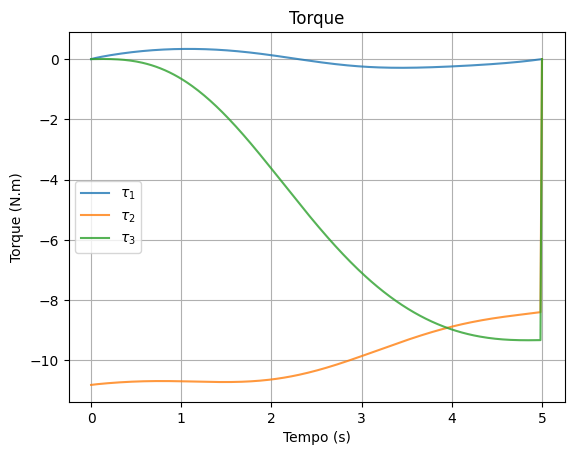

In [ ]:
# Torque / Erros
plt.plot(tgrid, tau, alpha=0.8, label=[f'$\\tau_{i+1}$' for i in range(r.dof)])
plt.title('Torque')
plt.ylabel('Torque (N.m)')
plt.xlabel('Tempo (s)')
plt.grid()
plt.legend()

## --> Plot dos resultados

- Aqui você tem que escolher qual vc quer visualizar: q, dq ou ddq

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequen

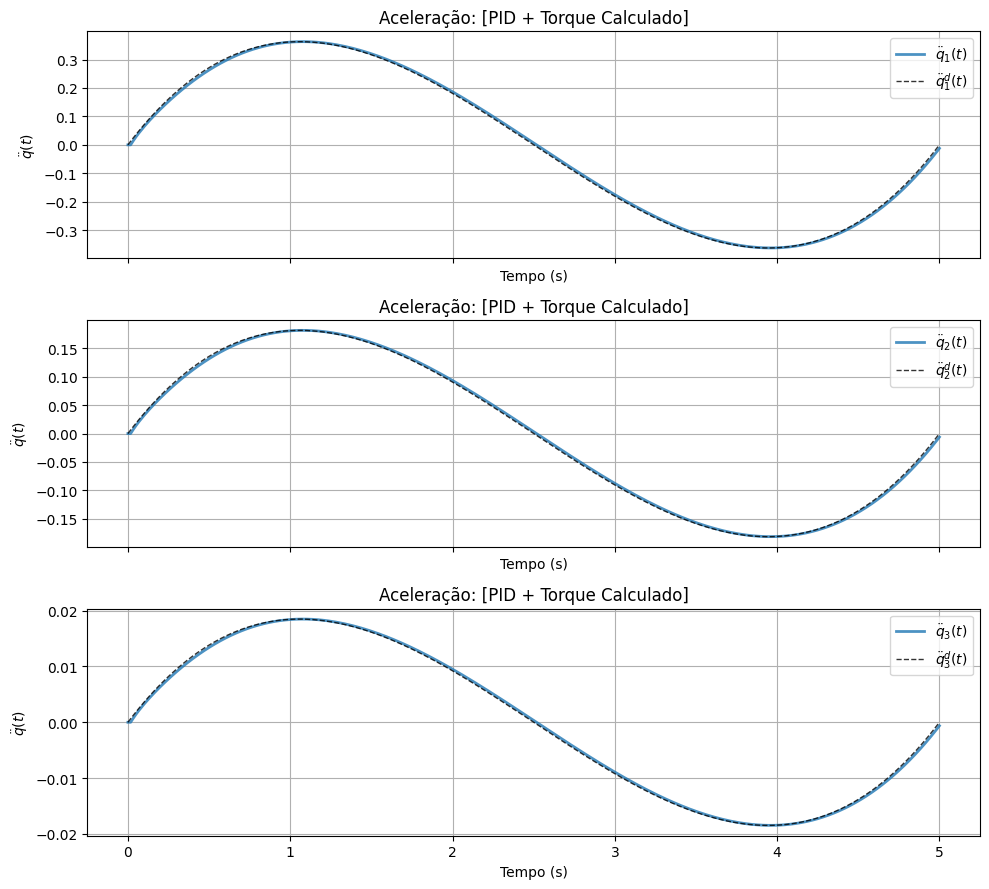

In [197]:
# Escolha de qual visualizar
plotar = 'ddq'        # q, dq, ddq

data = {'q': q, 'dq': dq, 'ddq': ddq}
data_d = {'q': q_ds, 'dq': dq_ds, 'ddq': ddq_ds}
lbl = {'q': ['$q_1(t)$', '$q_2(t)$', '$q_3(t)$'],
       'dq': ['$\dot{q}_1(t)$', '$\dot{q}_2(t)$', '$\dot{q}_3(t)$'],
       'ddq': ['$\ddot{q}_1(t)$', '$\ddot{q}_2(t)$', '$\ddot{q}_3(t)$']}
lbl_d = {'q': ['$q_1^d(t)$', '$q_2^d(t)$', '$q_3^d(t)$'],
         'dq': ['$\dot{q}_1^d(t)$', '$\dot{q}_2^d(t)$', '$\dot{q}_3^d(t)$'],
         'ddq': ['$\ddot{q}_1^d(t)$', '$\ddot{q}_2^d(t)$', '$\ddot{q}_3^d(t)$']}
title = {'q': 'Posição', 'dq': 'Velocidade', 'ddq': 'Aceleração'}
ylbl = {'q': 'q(t)', 'dq': '$\dot{q}(t)$', 'ddq': '$\ddot{q}(t)$'}

fig, axs = plt.subplots(3,1, figsize=(10,3*3), tight_layout=True, sharex=True)
for i, ax in enumerate(axs):
    ax.plot(tgrid, data[plotar].T[i], lw=2, label=lbl[plotar][i], alpha=.8)
    ax.plot(tgrid, data_d[plotar].T[i], linestyle='--', color='k', lw=1, label=lbl_d[plotar][i], alpha=.8)
    title0 = {'tc': 'PID + Torque Calculado', 'classico': 'PID Clássico', 'classico_maximos': 'PID Clássico (Máximos)'}
    ax.set_title(f'{title[plotar]}: [{title0[pid]}]')
    ax.set_ylabel(ylbl[plotar])
    ax.set_xlabel('Tempo (s)')
    ax.grid()
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.legend(loc='upper right')


## --> Explicação PID Clássico implementado

Claro! Aqui está a explicação **resumida, clara e completa** da derivação do controle **PID clássico** com base no que você implementou:

---

#### 🎯 **Objetivo**

Controlar um manipulador robótico usando um **controle PID direto** baseado na **dinâmica linearizada** do robô, de modo que o **erro de seguimento** tenda a zero com desempenho especificado.

---

#### ⚙️ **1. Dinâmica do manipulador (linearizada)**

Você começou da dinâmica completa:

$$
\tau = M(q)\ddot{q} + C(q, \dot{q})\dot{q} + G(q)
$$

E a **linearizou** em torno de um ponto de operação $(q_0, \dot{q}_0)$, obtendo:

$$
\tau \approx M_0 \ddot{q} + B_0 \dot{q} + K_0 q
$$

* $M_0 = M(q_0)$
* $B_0 = C(q_0, \dot{q}) \cdot \dot{q}$ aproximado numericamente
* $K_0 = \left.\frac{\partial G}{\partial q}\right|_{q_0}$ via diferenças finitas

---

#### 🧩 **2. Controle PID aplicado**

Você implementou o controle com:

$$
\tau = -K_p e - K_d \dot{e} - K_i \int e dt
\quad \text{com} \quad e = q_d - q
$$

Substituindo na dinâmica:

$$
M_0 \ddot{q} + B_0 \dot{q} + K_0 q = -K_p e - K_d \dot{e} - K_i \int e dt
$$

---

#### 🔁 **3. Reescrevendo em função do erro**

Usando $e = q_d - q \Rightarrow q = q_d - e$, etc., obtém-se:

$$
M_0 \ddot{e} + (B_0 - K_d)\dot{e} + (K_0 - K_p)e - K_i \int e = 0
$$

---

#### 🧠 **4. Escolha desejada da dinâmica do erro**

Você especificou que o erro deve obedecer à equação de 3ª ordem:

$$
\ddot{e} + 2\zeta \omega_n \dot{e} + \omega_n^2 e + \omega_n^2 p \int e dt = 0
$$

Comparando com a equação obtida, e multiplicando ambos os lados por $M_0$, temos:

$$
M_0 \ddot{e} + 2\zeta\omega_n M_0 \dot{e} + \omega_n^2 M_0 e + \omega_n^2 p M_0 \int e = 0
$$

---

#### 🧮 **5. Derivação dos ganhos**

Comparando termo a termo com:

$$
M_0 \ddot{e} + (B_0 - K_d)\dot{e} + (K_0 - K_p)e - K_i \int e = 0
$$

Identificamos os ganhos ideais como:

$$
\boxed{
\begin{aligned}
K_d &= B_0 - 2\zeta \omega_n M_0 \\
K_p &= K_0 - \omega_n^2 M_0 \\
K_i &= -\omega_n^2 p M_0
\end{aligned}
}
$$

Essas fórmulas levam em conta:

* A estrutura da dinâmica linearizada
* O sinal negativo do torque implementado
* O desempenho desejado (via $\omega_n$, $\zeta$, $p$)

---

#### ✅ **Resumo geral**

| Etapa                  | Resultado                                                                    |
| ---------------------- | ---------------------------------------------------------------------------- |
| Modelo linear usado    | $M_0 \ddot{q} + B_0 \dot{q} + K_0 q = \tau$                                  |
| Controle implementado  | $\tau = -K_p e - K_d \dot{e} - K_i \int e$                                   |
| Equação do erro obtida | $M_0 \ddot{e} + (B_0 - K_d)\dot{e} + (K_0 - K_p)e - K_i \int e = 0$          |
| Equação desejada       | $\ddot{e} + 2\zeta\omega_n \dot{e} + \omega_n^2 e + \omega_n^2 p \int e = 0$ |
| Ganhos resultantes     | $K_d = B_0 - 2\zeta \omega_n M_0$, etc.                                      |

---

Se quiser, posso montar isso em LaTeX ou slide para documentação. Deseja?


## --> Explicação PID + Torque Calculado implementado

---

#### ✅ **1. Modelo da dinâmica do manipulador**

A dinâmica completa é:

$$
\tau = M(q)\ddot{q} + C(q, \dot{q})\dot{q} + G(q)
$$

---

#### ✅ **2. Controle PID por torque calculado**

Você aplica:

$$
\tau = M(q)\left( \ddot{q}_d + K_d \dot{e} + K_p e + K_i \int e \right) + C(q, \dot{q}) \dot{q} + G(q)
\quad \text{com} \quad e = q_d - q
$$

---

#### ✅ **3. Substituindo na dinâmica**

Substituindo na equação da dinâmica:

$$
M(q)\ddot{q} + C(q, \dot{q})\dot{q} + G(q) = M(q)\left( \ddot{q}_d + K_d \dot{e} + K_p e + K_i \int e \right) + C(q, \dot{q}) \dot{q} + G(q)
$$

Cancelando os termos iguais nos dois lados:

$$
M(q)\ddot{q} = M(q)\left( \ddot{q}_d + K_d \dot{e} + K_p e + K_i \int e \right)
\Rightarrow
\ddot{q} = \ddot{q}_d + K_d \dot{e} + K_p e + K_i \int e
$$

Como:

$$
\ddot{e} = \ddot{q}_d - \ddot{q}
\Rightarrow
\ddot{e} = - K_d \dot{e} - K_p e - K_i \int e
$$

---

#### ✅ **4. Equação do erro**

$$
\boxed{
\ddot{e} + K_d \dot{e} + K_p e + K_i \int e = 0
}
$$

Nosso objetivo é que o erro siga a equação desejada de 3ª ordem com desempenho especificado:

$$
\ddot{e} + a_2 \dot{e} + a_1 e + a_0 \int e = 0
$$

---

#### ✅ **5. Escolha dos coeficientes desejados (a partir dos pólos)**

Queremos que a função de transferência do erro tenha os pólos:

$$
(s^2 + 2\zeta \omega_n s + \omega_n^2)(s + p)
\Rightarrow
s^3 + a_2 s^2 + a_1 s + a_0
$$

Multiplicando:

$$
(s^2 + 2\zeta \omega_n s + \omega_n^2)(s + p) =
s^3 + (2\zeta \omega_n + p) s^2 + (\omega_n^2 + 2\zeta \omega_n p) s + \omega_n^2 p
$$

---

#### ✅ **6. Identificação dos ganhos PID**

Comparando termo a termo com a equação do erro:

$$
\ddot{e} + K_d \dot{e} + K_p e + K_i \int e = 0
$$

Obtemos:

$$
\boxed{
\begin{aligned}
K_d &= 2\zeta \omega_n + p \\
K_p &= \omega_n^2 + 2\zeta \omega_n p \\
K_i &= \omega_n^2 p
\end{aligned}
}
$$

---

#### ✅ **Conclusão**

Esses são os ganhos ideais do **controle PID com torque calculado**, projetado para garantir uma dinâmica do erro com:

* Pólos complexos conjugados de desempenho especificado por $\zeta$ e $\omega_n$
* Um pólo real adicional $-p$ afastado

Você aplicou corretamente essa lógica. Esses ganhos são **escalar por junta**, e em implementação você usa isso em cada linha da matriz diagonal dos ganhos.


### Extra

In [194]:
# # Choose a function or expression
# f = r.torques

# # Options (basicamente equivalentes)
# tau = f.subs(substitution_dict).simplify()        # For substitution (can be other symbolic expression, i.e.)
# # f.evalf(subs=substitution_dict).simplify()  # For numeric substitution and evaluation
# tau

In [195]:
# # To evaluate with the desired values for q, dq and ddq:
# q_d = [pi/2, pi/4, 3]
# dq_d = [30, 20, 13]
# ddq_d = [5, 3, 1]

# # Prestar atenção, a ordem de substituição é: ddq, dq, q
# #   Se apenas q for setada, dq e ddq são calculados automaticamente, pois são suas derivadas. (i.e., se colocar constantes, dq e ddq são ZERO)
# #   Se apenas dq for setada, ddq é calculada automaticamente, pois é sua derivada. (q não sofre alteração)
# #   Se todos os valores forem setados, segue-se a ordem de substituição, para que o sistema não identifique automaticamente os valores das derivadas e considere os valores dados.
# #   Tomar cuidado quando for substituir.
# # Interessante: podemos colocar uma trajetória desejada em função do tempo para seguir q_d(t), que os cálculos consideram as derivadas automaticamente: ver Exemplo 2
# # Exemplo 1
# r.eval_dinamics(tau=tau, q_d=q_d, dq_d=dq_d, ddq_d=ddq_d)

# # Exemplo 2: 
# # Trajetória plano X-Y [r.t, exp(-r.t), 0] (para substituir valores de t, basta: <res>.subs('t', valor) ou <res>.subs(r.t, valor))
# r.eval_dinamics(tau=tau, q_d=[r.t, exp(-r.t), 0]).subs('t', 4)   # .subs('t', 4)